# Этап 1: Получение данных с GitHub и записывание их в SQLite

In [266]:
# import git
# SOURCE_URL = 'https://github.com/CSSEGISandData/COVID-19'
# DATA_PATH = '/data'
# git.Repo.clone_from(SOURCE_URL, DATA_PATH)

## Импорт

In [267]:
import sqlite3 as sl
import csv
import os
import re
from re import search



## Функции и переменные

In [268]:


def GetValuesPart(text):
    return re.sub('\w+[^,]', '?', text)

def ReplaceFields(text, fieldReplaceStorage):
    for key in fieldReplaceStorage:
        text = text.replace(key, fieldReplaceStorage[key])
    return text  

def CreateTableInDB(nameDB, query, queryUS):
    with con:
        cur.execute(query)
        cur.execute(queryUS)

def GetFileNameList(path):
    result = []
    for root, dirs, files in os.walk(path): 
        for file in files: 
            result.append(os.path.join(root,file).replace("\\", "/"))
    return result        
    
def ReplaceInList(row, replaceable, on):
    result = []
    for element in row:
        element = element.replace(replaceable, on)
        result.append(element)
    return result    

def GetFileDateFromName(name):
    return re.search('\d+-\d+-\d+', name).group() 

def AddFileDateFieldToText(headRow):
    if search("\w+", headRow):
        return headRow + ",File_Date"
    else:
      return "File_Date"

def ImportDataFromFileReaderToDB(fileReader, fileDate, insertQuery):
    for row in fileReader:
        row = ReplaceInList(row, "/", "-")
        row.append(fileDate)
        cur.execute(insertQuery, row)

def GetHeadRowFromFileReader(fileReader):
    headRow = ",".join(next(fileReader))
    headRow = ReplaceFields(headRow, fieldReplaceStorage) 
    return headRow

def ImportDataFromFilesToDB(fileNameList, nameTable):
    for name in fileNameList:
        if (".csv" in name):
            with open(name, encoding='utf-8') as r_file:
                fileReader = csv.reader(r_file, delimiter = ",")
                headRow = AddFileDateFieldToText(GetHeadRowFromFileReader(fileReader))
                valuesPart = GetValuesPart(headRow)
                insertQuery = f"INSERT INTO {nameTable} ({headRow}) values({valuesPart}) " 
                fileDate = GetFileDateFromName(name) 
                ImportDataFromFileReaderToDB(fileReader, fileDate, insertQuery)  
                                    

def ImportDataFromFoldersToDB(nameTable, folderPathes):
    try:
        fileNameList = GetFileNameList(folderPathes[0])
        ImportDataFromFilesToDB(fileNameList, nameTable)
        fileNameList = GetFileNameList(folderPathes[1])
        ImportDataFromFilesToDB(fileNameList, nameTableUS)               
        con.commit()
    
    finally:
        if cur is not None:
            cur.close()

        if con is not None:
            con.close()

fieldReplaceStorage = {
    "Incidence_Rate": "Incident_Rate",
    "Lat,": "Latitude,",
    "Long_": "Longitude",
    "/": "_",
    " ": "_",
    "-": "_"
}

nameTable = "statistics"
nameTableUS = "statisticsUS"
nameDB = "corona_statistics.db"
path1 = "D:\GitHub\DA\csse_covid_19_data\csse_covid_19_daily_reports"
path2 = "D:\GitHub\DA\csse_covid_19_data\csse_covid_19_daily_reports_us"
pathList = [path1, path2]

query = """
        CREATE TABLE statistics (
        FIPS                 INT,
        Admin2               TEXT,
        Province_State       TEXT,
        Country_Region       TEXT,
        Last_Update          DATETIME,
        Latitude             REAL,
        Longitude            REAL,
        Confirmed            INT, 
        Deaths               INT, 
        Recovered            INT, 
        Active               INT, 
        Combined_Key         TEXT,
        Incident_Rate        REAL,
        Case_Fatality_Ratio  REAL,
        File_Date            DATE
    );
    """


queryUS = """
        CREATE TABLE statisticsUS (
        FIPS                 INT,
        Province_State       TEXT,
        Country_Region       TEXT,
        Last_Update          DATETIME,
        Latitude             REAL, 
        Longitude            REAL,
        Confirmed            INT, 
        Deaths               INT, 
        Recovered            INT, 
        Active               INT, 
        Incident_Rate        REAL,
        Case_Fatality_Ratio  REAL,
        Total_Test_Results   REAL,
        People_Hospitalized  INT,
        UID                  INT,
        ISO3                 TEXT,
        Testing_Rate         REAL,
        Hospitalization_Rate REAL,
        People_Tested        INT,
        Mortality_Rate       REAL,
        Cases_28_Days        REAL,
        Deaths_28_Days       REAL,
        File_Date            DATE
    );
    """

## Подключение

In [269]:
con = sl.connect(nameDB)  
cur = con.cursor()  

## Создание таблиц

In [270]:
CreateTableInDB(nameDB, query, queryUS)

## Импорт данных в SQLite

In [271]:
ImportDataFromFoldersToDB(nameTable, pathList)

# Этап 2: Обработка данных

## Импорт

In [272]:
import pandas as pd
import sqlite3

## Подключение

In [273]:
con = sqlite3.connect("corona_statistics.db")
cur = con.cursor()

## Чтение данных с SQLite

In [274]:
query = "SELECT * FROM statistics"
queryUS = "SELECT * FROM statisticsUS"
df = pd.read_sql(query, con)
dfUS = pd.read_sql(queryUS, con)

## Reports

## 1) Получение представления о таблицах, с которыми будем работать

In [275]:
df.head(100)

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,File_Date
0,,,,Afghanistan,2021-01-02 05:22:33,33.93911,67.709953,52513,2201,41727,0,Afghanistan,0.0,4.252222,01-01-2021
1,,,,Albania,2021-01-02 05:22:33,41.1533,20.1683,58316,1181,33634,23501,Albania,2026.409062,2.025173,01-01-2021
2,,,,Algeria,2021-01-02 05:22:33,28.0339,1.6596,99897,2762,67395,29740,Algeria,227.809861,2.764848,01-01-2021
3,,,,Andorra,2021-01-02 05:22:33,42.5063,1.5218,8117,84,7463,570,Andorra,10505.403482,1.034865,01-01-2021
4,,,,Angola,2021-01-02 05:22:33,-11.2027,17.8739,17568,405,11146,6017,Angola,53.452981,2.305328,01-01-2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,,,Araucania,Chile,2021-01-02 05:22:33,-38.9489,-72.3311,23161,311,21736,1114,"Araucania, Chile",2419.600846,1.342774,01-01-2021
96,,,Arica y Parinacota,Chile,2021-01-02 05:22:33,-18.594,-69.4785,10859,225,10408,226,"Arica y Parinacota, Chile",4803.421979,2.072014,01-01-2021
97,,,Atacama,Chile,2021-01-02 05:22:33,-27.5661,-70.0503,8520,113,8328,79,"Atacama, Chile",2948.668254,1.326291,01-01-2021
98,,,Aysen,Chile,2021-01-02 05:22:33,-45.9864,-73.7669,1588,15,1436,137,"Aysen, Chile",1539.386184,0.944584,01-01-2021


In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2199731 entries, 0 to 2199730
Data columns (total 15 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   FIPS                 object
 1   Admin2               object
 2   Province_State       object
 3   Country_Region       object
 4   Last_Update          object
 5   Latitude             object
 6   Longitude            object
 7   Confirmed            object
 8   Deaths               object
 9   Recovered            object
 10  Active               object
 11  Combined_Key         object
 12  Incident_Rate        object
 13  Case_Fatality_Ratio  object
 14  File_Date            object
dtypes: object(15)
memory usage: 251.7+ MB


## 2) Изменяем типы данных кроме Case_Fatality_Ratio, так как для него будут рассчитываться значения из других полей

In [277]:
def SetStringType(df, *columnNames):
    for name in columnNames:
        df[name] = df[name].astype("string")

In [278]:
df["Last_Update"]         = pd.to_datetime(df["Last_Update"])
df['File_Date']           = pd.to_datetime(df['File_Date'])
df["FIPS"]                = pd.to_numeric(df["FIPS"])
df["Confirmed"]           = pd.to_numeric(df["Confirmed"])
df["Deaths"]              = pd.to_numeric(df["Deaths"])
df["Recovered"]           = pd.to_numeric(df["Recovered"])
df["Active"]              = pd.to_numeric(df["Active"])
df["Latitude"]            = pd.to_numeric(df["Latitude"])
df["Longitude"]           = pd.to_numeric(df["Longitude"])
df["Incident_Rate"]       = pd.to_numeric(df["Incident_Rate"])

SetStringType(df, "Admin2", "Province_State", "Country_Region", "Combined_Key")

## Проверка на нулевые значения

In [279]:
df.isnull().sum()

FIPS                   392274
Admin2                   8882
Province_State              0
Country_Region              0
Last_Update                 0
Latitude                50278
Longitude               50278
Confirmed                  28
Deaths                    434
Recovered              750546
Active                 759891
Combined_Key             8882
Incident_Rate          268767
Case_Fatality_Ratio    225348
File_Date                   0
dtype: int64

## FIPS, Admin2, Incident_Rate не изменяем, в остальных null значения заполняем 0

In [280]:
df["Latitude"].fillna(0, inplace=True)
df["Longitude"].fillna(0, inplace=True)
df["Active"].fillna(0, inplace=True)
df["Deaths"].fillna(0, inplace=True)
df["Recovered"].fillna(0, inplace=True)
df["Confirmed"].fillna(0, inplace=True)

## Проверка и удаление аномальных значений

### FIPS - в порядке

In [281]:
print('Min: ', df['FIPS'].min())

Min:  60.0


### Last Update - в порядке

In [282]:
print('Min: ', df['Last_Update'].min())
print('Max: ', df['Last_Update'].max())

Min:  2020-01-22 17:00:00
Max:  2021-10-08 04:21:25


### Confirmed - ошибка

In [283]:
print('Min: ', df['Confirmed'].min())

Min:  -302844.0


In [284]:
df = df.drop(df[df.Confirmed < 0].index)

### Deaths - ошибка

In [285]:
print('Min: ', df['Deaths'].min())

Min:  -178.0


In [286]:
df = df.drop(df[df.Deaths < 0].index)

### Recovered - ошибка

In [287]:
print('Min: ', df['Recovered'].min())

Min:  -854405.0


In [288]:
df = df.drop(df[df.Recovered < 0].index)

### Active - ошибка

In [289]:
print('Min: ', df['Active'].min())

Min:  -6298082.0


In [290]:
df = df.drop(df[df.Active < 0].index)

In [291]:
(df['Country_Region'] == '').unique()

<BooleanArray>
[False]
Length: 1, dtype: boolean

In [292]:
(df['Province_State'] == '').unique()

<BooleanArray>
[True, False]
Length: 2, dtype: boolean

## Так как Combined_Key формируется из Province_State и Country_Region и последний не имет пустых значений, то заполняем Combined_Key с помощью этих полей

In [293]:
df['Combined_Key'] = df['Country_Region']
existProvince_State = df['Province_State'].notna()
df.loc[existProvince_State, 'Combined_Key'] = df.loc[existProvince_State, 'Province_State'] + ' ' + df.loc[existProvince_State, 'Combined_Key']

## Case_Fatality_Ratio вычисляется по формуле, взятой с GitHub Case-Fatality Ratio (%) = Number recorded deaths / Number cases

In [294]:
#там, где Confirmed(знаменатель) пуст, чтобы избежать ошибок при делении сразу ставим у Case_Fatality_Ratio
df.loc[df['Confirmed'] == 0, 'Case_Fatality_Ratio'] = 0 
df['Case_Fatality_Ratio'].fillna(df['Deaths'] / df['Confirmed'] * 100, inplace=True)

## Получим обновленную информацию

In [295]:
df.isnull().sum()

FIPS                   389824
Admin2                   8882
Province_State              0
Country_Region              0
Last_Update                 0
Latitude                    0
Longitude                   0
Confirmed                   0
Deaths                      0
Recovered                   0
Active                      0
Combined_Key                0
Incident_Rate          265488
Case_Fatality_Ratio         0
File_Date                   0
dtype: int64

## Reports-US

## 1) Получение представления о таблицах, с которыми будем работать

In [296]:
dfChina = df['Country_Region'] == 'China'
dfChina.head(10)

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
Name: Country_Region, dtype: boolean

In [297]:
dfUS.head(100)

,FIPS,Province_State,Country_Region,Last_Update,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,...,People_Hospitalized,UID,ISO3,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate,Cases_28_Days,Deaths_28_Days,File_Date
0,1,Alabama,US,2021-01-02 05:30:44,32.3182,-86.9023,365747,4872,202137,158738,...,,84000001,USA,38448.804196,,None,None,NaN,NaN,01-01-2021
1,2,Alaska,US,2021-01-02 05:30:44,61.3707,-152.4044,47019,206,7165,39615,...,,84000002,USA,174391.185778,,None,None,NaN,NaN,01-01-2021
2,60,American Samoa,US,2021-01-02 05:30:44,-14.271,-170.132,0,0,,0,...,,16,ASM,3846.084722,,None,None,NaN,NaN,01-01-2021
3,4,Arizona,US,2021-01-02 05:30:44,33.7298,-111.4312,530267,9015,76934,444318,...,,84000004,USA,39551.860582,,None,None,NaN,NaN,01-01-2021
4,5,Arkansas,US,2021-01-02 05:30:44,34.9697,-92.3731,229442,3711,199247,26484,...,,84000005,USA,67979.497674,,None,None,NaN,NaN,01-01-2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,37,North Carolina,US,2021-01-03 05:30:33,35.6301,-79.8064,558437,6892,403488,148057,...,,84000037,USA,67499.306832,,None,None,NaN,NaN,01-02-2021
96,38,North Dakota,US,2021-01-03 05:30:33,47.5289,-99.784,92891,1317,89582,1999,...,,84000038,USA,169287.669507,,None,None,NaN,NaN,01-02-2021
97,69,Northern Mariana Islands,US,2021-01-03 05:30:33,15.0979,145.6739,122,2,29,91,...,,580,MNP,31827.578703,,None,None,NaN,NaN,01-02-2021
98,39,Ohio,US,2021-01-03 05:30:33,40.3888,-82.7649,714673,13919,573641,132015,...,,84000039,USA,66891.445877,,None,None,NaN,NaN,01-02-2021


In [298]:
dfUS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31570 entries, 0 to 31569
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   FIPS                  31570 non-null  object 
 1   Province_State        31570 non-null  object 
 2   Country_Region        31570 non-null  object 
 3   Last_Update           31570 non-null  object 
 4   Latitude              31570 non-null  object 
 5   Longitude             31570 non-null  object 
 6   Confirmed             31570 non-null  int64  
 7   Deaths                31570 non-null  int64  
 8   Recovered             31570 non-null  object 
 9   Active                31570 non-null  object 
 10  Incident_Rate         31570 non-null  object 
 11  Case_Fatality_Ratio   19314 non-null  object 
 12  Total_Test_Results    19314 non-null  object 
 13  People_Hospitalized   31570 non-null  object 
 14  UID                   31570 non-null  int64  
 15  ISO3               

## 2) Изменяем типы данных

In [299]:
def SetStringType(df, *columnNames):
    for name in columnNames:
        df[name] = df[name].astype("string")

In [300]:
dfUS['Last_Update']          = pd.to_datetime(dfUS['Last_Update'])
dfUS['File_Date']            = pd.to_datetime(dfUS['File_Date'])
dfUS["FIPS"]                 = pd.to_numeric(dfUS["FIPS"])
dfUS["Confirmed"]            = pd.to_numeric(dfUS["Confirmed"])
dfUS["Deaths"]               = pd.to_numeric(dfUS["Deaths"])
dfUS["Recovered"]            = pd.to_numeric(dfUS["Recovered"])
dfUS["Active"]               = pd.to_numeric(dfUS["Active"])
dfUS["Latitude"]             = pd.to_numeric(dfUS["Latitude"])
dfUS["Longitude"]            = pd.to_numeric(dfUS["Longitude"])
dfUS["Incident_Rate"]        = pd.to_numeric(dfUS["Incident_Rate"])
dfUS["Case_Fatality_Ratio"]  = pd.to_numeric(dfUS["Case_Fatality_Ratio"])
dfUS["Total_Test_Results"]   = pd.to_numeric(dfUS["Total_Test_Results"])
dfUS["People_Hospitalized"]  = pd.to_numeric(dfUS["People_Hospitalized"])
dfUS["UID"]                  = pd.to_numeric(dfUS["UID"])
dfUS["Testing_Rate"]         = pd.to_numeric(dfUS["Testing_Rate"])
dfUS["Hospitalization_Rate"] = pd.to_numeric(dfUS["Hospitalization_Rate"])
dfUS["People_Tested"]        = pd.to_numeric(dfUS["People_Tested"])
dfUS["Mortality_Rate"]       = pd.to_numeric(dfUS["Mortality_Rate"])
dfUS["Cases_28_Days"]        = pd.to_numeric(dfUS["Cases_28_Days"])
dfUS["Deaths_28_Days"]       = pd.to_numeric(dfUS["Deaths_28_Days"])

SetStringType(dfUS, "Province_State", "Country_Region", "ISO3")

## Проверка на нулевые значения

In [301]:
dfUS.isnull().sum()

FIPS                       19
Province_State              0
Country_Region              0
Last_Update                19
Latitude                 1106
Longitude                1106
Confirmed                   0
Deaths                      0
Recovered               16448
Active                  12487
Incident_Rate            1106
Case_Fatality_Ratio     12587
Total_Test_Results      12940
People_Hospitalized     26441
UID                         0
ISO3                        0
Testing_Rate             1124
Hospitalization_Rate    26441
People_Tested           19754
Mortality_Rate          19543
Cases_28_Days           31454
Deaths_28_Days          31454
File_Date                   0
dtype: int64

## FIPS, Incident_Rate не изменяем. 19 null значений в Last_Update говорят об не актуальности информации в этих строках, поэтому необходимо зачистить их 

In [302]:
dfUS = dfUS.dropna(subset=['Last_Update'])

## Изначально Hospitalization_Rate, People_Hospitalized не заполнены, поэтому удаляем эти столбцы

In [303]:
del dfUS['People_Hospitalized'], dfUS['Hospitalization_Rate']

## В Cases_28_Days и Deaths_28_Days подозрительно много null значений, выявим, в каких файлах появлялись эти поля

In [304]:
path = "D:\GitHub\DA\csse_covid_19_data\csse_covid_19_daily_reports_us"
fileNameList = GetFileNameList(path)
for name in fileNameList:
    if (".csv" in name):
        with open(name, encoding='utf-8') as r_file:
            fileReader = csv.reader(r_file, delimiter = ",")
            headRow = AddFileDateFieldToText(GetHeadRowFromFileReader(fileReader))
            if (("Cases_28_Days" in headRow) | ("Deaths_28_Days" in headRow)):
                print(name)

D:/GitHub/DA/csse_covid_19_data/csse_covid_19_daily_reports_us/08-09-2021.csv
D:/GitHub/DA/csse_covid_19_data/csse_covid_19_daily_reports_us/08-10-2021.csv


## Данные поля практически не влиют на статистику из-за масштабы последней, поэтому их можно удалить

In [305]:
del dfUS['Cases_28_Days'], dfUS['Deaths_28_Days']

## В остальных null значения заменяем на 0

In [306]:
dfUS["Latitude"].fillna(0, inplace=True)
dfUS["Longitude"].fillna(0, inplace=True)
dfUS["Active"].fillna(0, inplace=True)
dfUS["Recovered"].fillna(0, inplace=True)
dfUS["Total_Test_Results"].fillna(0, inplace=True)
dfUS["Testing_Rate"].fillna(0, inplace=True)
dfUS["People_Tested"].fillna(0, inplace=True)
dfUS["Mortality_Rate"].fillna(0, inplace=True)

## Проверка и удаление аномальных значений

### FIPS - в порядке

In [307]:
print('Min: ', dfUS['FIPS'].min())

Min:  1.0


### Last Update - в порядке

In [308]:
print('Min: ', dfUS['Last_Update'].min())
print('Max: ', dfUS['Last_Update'].max())

Min:  2020-04-12 23:18:15
Max:  2021-10-08 04:31:23


### Confirmed - в порядке

In [309]:
print('Min: ', dfUS['Confirmed'].min())

Min:  0


### Deaths - в порядке

In [310]:
print('Min: ', dfUS['Deaths'].min())

Min:  0


### Recovered - в порядке

In [311]:
print('Min: ', dfUS['Recovered'].min())

Min:  0.0


### Active - ошибка

In [312]:
print('Min: ', dfUS['Active'].min())

Min:  -120720.0


In [313]:
dfUS = dfUS.drop(dfUS[dfUS.Active < 0].index)

### Total_Test_Results - в порядке

In [314]:
print('Min: ', dfUS['Total_Test_Results'].min())

Min:  0.0


### People_Tested - в порядке

In [315]:
print('Min: ', dfUS['People_Tested'].min())

Min:  0.0


### Mortality_Rate - в порядке

In [316]:
print('Min: ', dfUS['Mortality_Rate'].min())

Min:  0.0


## Case_Fatality_Ratio вычисляется по аналогии с Reports, взятой с GitHub Case-Fatality Ratio (%) = Number recorded deaths / Number cases

In [317]:
#там, где Confirmed(знаменатель) пуст, чтобы избежать ошибок при делении сразу ставим у Case_Fatality_Ratio
dfUS.loc[dfUS['Confirmed'] == 0, 'Case_Fatality_Ratio'] = 0 
dfUS['Case_Fatality_Ratio'].fillna(dfUS['Deaths'] / dfUS['Confirmed'] * 100, inplace=True)

## Получим обновленную информацию

In [318]:
dfUS.isnull().sum()

FIPS                      0
Province_State            0
Country_Region            0
Last_Update               0
Latitude                  0
Longitude                 0
Confirmed                 0
Deaths                    0
Recovered                 0
Active                    0
Incident_Rate          1088
Case_Fatality_Ratio       0
Total_Test_Results        0
UID                       0
ISO3                      0
Testing_Rate              0
People_Tested             0
Mortality_Rate            0
File_Date                 0
dtype: int64

## Unconnection

In [319]:
cur.close()
con.close()

# Этап 3: Извлечение информации из данных

## Импорт

In [320]:
import matplotlib.pyplot as plt
import datetime
import numpy as np 
 

## Гипотеза 1 - Китай при своей подготовке к инцидентам подобным COVID-19 отреагировал значительно лучше многих стран с меньшей численностью населения.

## Гипотеза 2 - Из-за событий в Америке, мешавших борьбе с COVID-19(различные акции, митинги с большим количеством участвующих лиц), статистика смертности значительно превосходит статистику других стран.

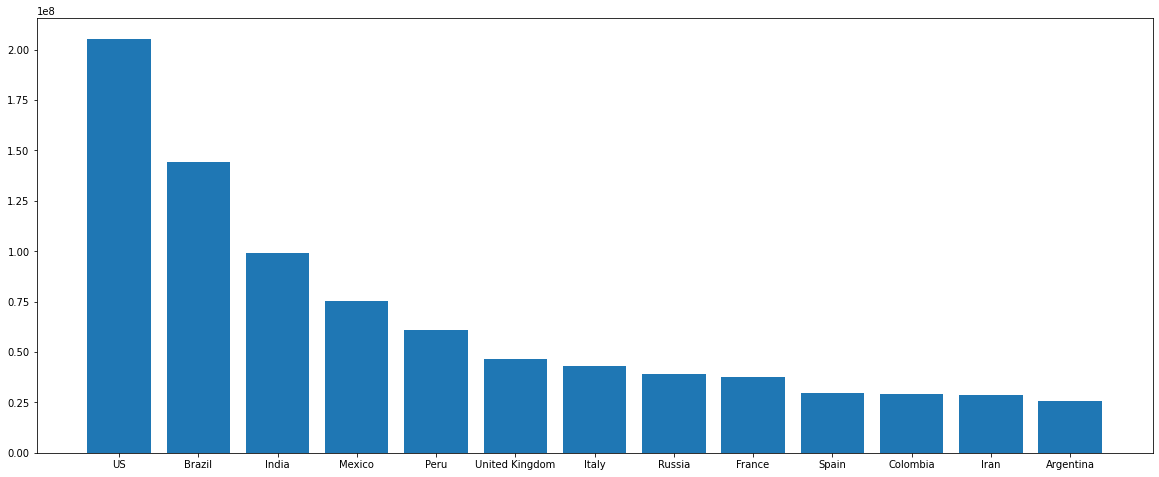

In [321]:
data = df
countryDeaths = pd.DataFrame({"Country_Region": data['Country_Region'], "Deaths": data['Deaths']})
countryDeaths = countryDeaths.groupby(['Country_Region']).sum()
countryDeaths = pd.DataFrame({"Country_Region": countryDeaths.index, "Deaths": countryDeaths['Deaths']})
countryDeaths = countryDeaths.sort_values(by='Deaths', ascending=False)
countryDeaths = countryDeaths.head(13);
plt.subplots(figsize=(20,8))
index = np.arange(13)
plt.xticks(index, countryDeaths['Country_Region'])
plt.bar(index, countryDeaths['Deaths'])
plt.show()

## Гипотеза 3 - При переходе на сезон повышенной заболеваемости гриппом(с лета на осень) заболеваемость COVID-19 растет(Возможно больные гриппом были ошибочны идентифицированы как больные COVID-19).

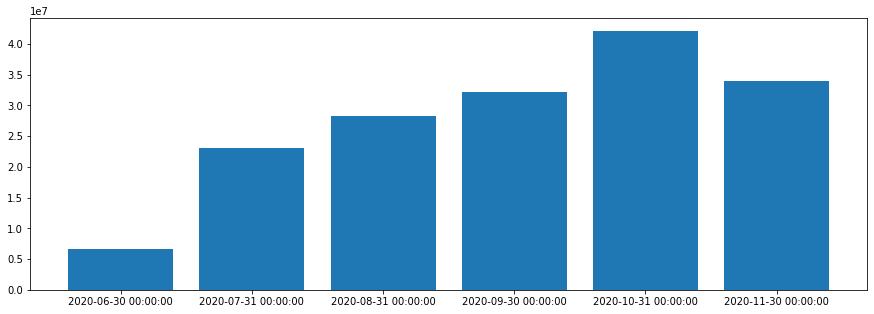

In [322]:

data = df[(df['Country_Region'] == 'Russia') & (df['Last_Update'] >= datetime.datetime(2020, 6, 20, 0, 0, 0)) & (df['Last_Update'] <= datetime.datetime(2020, 11, 20, 0, 0, 0))]
russiaConfirmed = pd.DataFrame({"Last_Update": data['Last_Update'], "Confirmed": data['Confirmed']})
russiaConfirmed = russiaConfirmed.groupby(pd.Grouper(key="Last_Update", freq="M")).sum()
russiaConfirmed = pd.DataFrame({"Last_Update": russiaConfirmed.index, "Confirmed": russiaConfirmed['Confirmed']})
russiaConfirmed = russiaConfirmed.head(6);
plt.subplots(figsize=(15, 5))
index = np.arange(6)
plt.xticks(index, russiaConfirmed['Last_Update'])
plt.bar(index, russiaConfirmed['Confirmed'])
plt.show()


### Под конец сезона грипппа стастиска больных COVID-19 спадает потому, что больных гриппом становится меньше и количество людей, которых ошибочно записали сходит на нет.  

## Гипотеза 4 - Климат оказывает влияние на распространенность COVID-19 на примере стран с приблизительно одинаковым количеством населения  

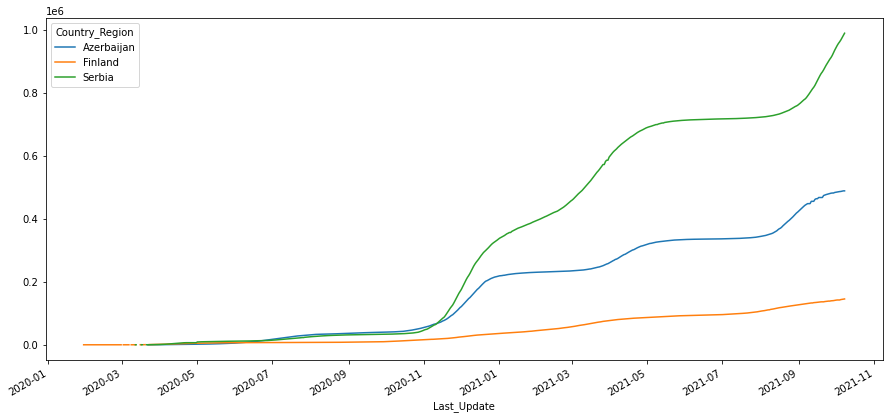

In [323]:
data = df[(df['Country_Region'] == 'Finland') | (df['Country_Region'] == 'Serbia') | (df['Country_Region'] == 'Azerbaijan')]
pd.pivot_table(data, values = 'Confirmed', columns = 'Country_Region', index='Last_Update').plot(figsize=(15,7));

### Климат в Финляндии(субарктический) осложняет распространение вируса из-за низкой температуры. Климат в Азербайджане(субтропический) замедляет распространение из-за выскоих температур. Климат Сербии(континентальный) является самым благоприятным для распространения COVID-19, что видно на графике.

## Гипотеза 5 - Более образованное население США больше предостерегается во время пандемии.

<AxesSubplot:ylabel='States'>

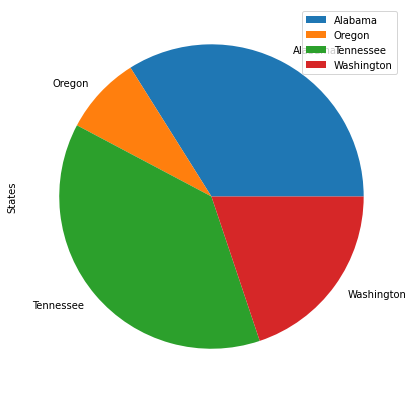

In [324]:
data = dfUS[(dfUS['Province_State'] == 'Washington') | (dfUS['Province_State'] == 'Oregon') | (dfUS['Province_State'] == 'Alabama') | (dfUS['Province_State'] == 'Tennessee')]
usaStates = pd.DataFrame({"Province_State": data['Province_State'], "Deaths": data['Deaths']})
usaStates = usaStates.groupby(['Province_State']).sum()   
usaStates = pd.DataFrame({"Province_State": usaStates.index, "Deaths": usaStates['Deaths']})
usaStates.plot.pie(y = 'Deaths', label = 'States', figsize=(7, 7))


### Штаты Алабама и Теннесси являются более развитыми экономически в сторону сельского хозяйства, из-за чего уровень образования у местного населения меньше чем, у населения штатов Вашингтон и Орегон. Более образованные люди верили в опасность коронавируса из-за чего предпринимали меры о защите и в следствии показатели смертей меньше. 

## Гипотеза 6 - Уровень ВВП не влияет на заболеваемость COVID-19 

<AxesSubplot:ylabel='Countries'>

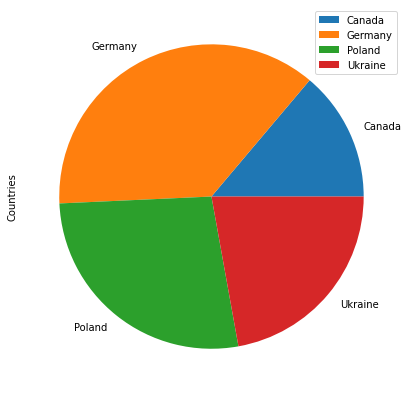

In [325]:
data = df[(df['Country_Region'] == 'Germany') | (df['Country_Region'] == 'Ukraine') | (df['Country_Region'] == 'Canada') | (df['Country_Region'] == 'Poland')]
countries = pd.DataFrame({"Country_Region": data['Country_Region'], "Confirmed": data['Confirmed']})
countries = countries.groupby(['Country_Region']).sum()   
countries = pd.DataFrame({"Country_Region": countries.index, "Confirmed": countries['Confirmed']})
countries.plot.pie(y = 'Confirmed', label = 'Countries', figsize=(7, 7))